In [1]:
from pylab import *
import h5py
import shutil
import tempfile
import sys
import caffe
import os
import sys
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
import pickle
import subprocess as sub
from collections import defaultdict
import itertools
import pickle
import time
import datetime
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline
# Take care with the paths -defaults ones from protobuf are not correct. Need to change snapshot and train / test data paths 

caffe_root = '/home/nikhil/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/'
os.chdir(baseline_dir)

caffe.set_device(1)
caffe.set_mode_gpu()

#Useful resources:
#http://stackoverflow.com/questions/33140000/how-to-feed-caffe-multi-label-data-in-hdf5-format
#http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb
#http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/01-learning-lenet.ipynb

In [2]:
import tables as tb
from sklearn import preprocessing
def load_data(data_path, input_node, preproc):
    data = tb.open_file(data_path, 'r')
    X_raw = data.get_node('/' + input_node)[:]
    if preproc == 'scale':
        X = preprocessing.scale(X_raw)
    elif preproc == 'norm_max':
        X = preprocessing.normalize(X_raw, norm='max')
    elif preproc == 'norm_l2':
        X = preprocessing.normalize(X_raw, norm='l2')
    else:
        X = X_raw
    data.close()
    return X

# Some defs to load data and extract encodings from trained net
import collections
def extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers, multi_task):
    os.chdir(os.path.dirname(net_file))
    net = caffe.Net(net_file, model_file, caffe.TEST)        
    
    print net.blobs.items()[0]
    print net.blobs.items()[1]
    
    #Get weights    
    layer_list = weight_layers
    wt_dict = collections.OrderedDict()
    print layer_list
    #print net._layer_names
    #for l, name in enumerate(net._layer_names):            
        #print l, name        
    for name in layer_list:
        wt_dict[name] = net.params[name][0].data
    
    BATCH_SIZE = batch_size        
    N = load_data(data_path, input_nodes[0],'no_preproc').shape[0]
    iters = int(np.ceil(N / float(BATCH_SIZE)))

    if not multi_task:
        code_layer = net.blobs[encoding_layer]
        out_shape = code_layer.data.shape    
        X_out = np.zeros(shape=(N, out_shape[1]))        
        print 'X_out.shape: {}'.format(X_out.shape)
        
    else:
        code_layer_adas13 = net.blobs[encoding_layer + '_ADAS13']
        code_layer_mmse = net.blobs[encoding_layer + '_MMSE']
        out_shape = code_layer_adas13.data.shape 
        X_out_adas13 = np.zeros(shape=(N, out_shape[1]))
        X_out_mmse = np.zeros(shape=(N, out_shape[1]))
        print 'X_out.shape: {},{}'.format(X_out_adas13.shape,X_out_mmse.shape)
    
    X_list = []
    data_layers = []
    for i, input_node in enumerate(input_nodes):
        X_list.append(load_data(data_path, input_node,'no_preproc'))
        data_layers.append(net.blobs.items()[i][1])    
        data_layers[i].reshape(BATCH_SIZE, X_list[i].shape[1]) # TODO: only works for 2-D inputs
    
    net.reshape()            
    print 'Extracting features from data...'
    
    for i in xrange(iters):
        print '.',
        for m, X in enumerate(X_list):
            X_b = X[i * BATCH_SIZE: (i+1) * BATCH_SIZE,:]
            batch_sampx = X_b.shape[0]
            # Pad last batch with zeros
            if X_b.shape[0] < BATCH_SIZE:
                #print 'Zero-padding last batch with {} rows'.format(BATCH_SIZE-X_b.shape[0])
                X_b = np.vstack((X_b,np.zeros((BATCH_SIZE-X_b.shape[0],X_b.shape[1]))))                       
            
            data_layers[m].data[...] = X_b
            
        net.forward()
        
        if not multi_task:
            X_out[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer.data[0:batch_sampx,:].copy()
        else:
            X_out_adas13[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer_adas13.data[0:batch_sampx,:].copy()
            X_out_mmse[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer_mmse.data[0:batch_sampx,:].copy()
            X_out = {'adas13':X_out_adas13,'mmse':X_out_mmse}
    return {'X_out':X_out, 'wt_dict':wt_dict}

In [66]:
from caffe import layers as L
from caffe import params as P

def adninet_ff_HC(hdf5, batch_size, node_sizes, dr, lr, tr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_L_HC,n.X_R_HC,n.y  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_L_HC,n.X_R_HC,n.y3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    elif Clinical_Scale == 'DX':
        n.X_L_HC,n.X_R_HC,n.dx_cat3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    elif Clinical_Scale == 'BOTH':
        n.X_L_HC,n.X_R_HC,n.y,n.y3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    #ff layers Left HC
    #n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['HC_L_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.L_ff1, in_place=True)
    n.dropL1 = L.Dropout(n.L_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers Right HC
    #n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['HC_R_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnR1 = L.ReLU(n.R_ff1, in_place=True)
    n.dropR1 = L.Dropout(n.R_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers Concat
    n.concat = L.Concat(n.L_ff1,n.R_ff1, concat_param=dict(axis=1))
    n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
    n.NLinEn3 = L.ReLU(n.ff3, in_place=True)
  
#     Task layers    
#     if Clinical_Scale == 'BOTH': ## Split layers (multitask)
#         n.ff1_ADAS13 = L.InnerProduct(n.ff3, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
#         n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        
#         n.ff1_MMSE = L.InnerProduct(n.ff3, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
#         n.NLin1MMSE = L.ReLU(n.ff1_MMSE, in_place=True)
#     else:
#         #n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['ff4'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))
#         n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
#         n.NLinEn4 = L.ReLU(n.ff4, in_place=True)
    
    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.177))          
    if Clinical_Scale == 'ADAS13':
        n.output = L.InnerProduct(n.ff3, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.y)            
    elif Clinical_Scale == 'MMSE':
        n.output = L.InnerProduct(n.ff3, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.y3)
    elif Clinical_Scale == 'DX':
        n.output = L.InnerProduct(n.ff3, num_output=3, weight_filler=dict(type='xavier'))
        n.loss = L.SoftmaxWithLoss(n.output, n.dx_cat3)
    elif Clinical_Scale == 'BOTH':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.y,loss_weight=tr['ADAS'])          
        n.output_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=1, weight_filler=dict(type='xavier'))
        n.MMSE_loss = L.EuclideanLoss(n.output_MMSE, n.y3,loss_weight=tr['MMSE'])  
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    
    return n.to_proto()

def adninet_ff_CT(hdf5, batch_size, node_sizes, dr, lr, tr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_CT,n.y  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_CT,n.y3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    elif Clinical_Scale == 'BOTH':
        n.X_CT,n.y,n.y3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    elif Clinical_Scale == 'DX':
        n.X_CT,n.dx_cat3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    n.ff1 = L.InnerProduct(n.X_CT, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.ff1, in_place=True)
    n.dropL1 = L.Dropout(n.ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['CT'])) 

    #Task Layers
    if Clinical_Scale == 'BOTH': ## Split layers (multitask)
        n.ff1_ADAS13 = L.InnerProduct(n.ff1, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        
        n.ff1_MMSE = L.InnerProduct(n.ff1, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1MMSE = L.ReLU(n.ff1_MMSE, in_place=True)        
    else:
        n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
        n.NLinEnL2 = L.ReLU(n.ff2, in_place=True)
        n.dropL2 = L.Dropout(n.ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    
    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.177))          
    if Clinical_Scale == 'ADAS13':
        n.output = L.InnerProduct(n.ff2, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.y)            
    elif Clinical_Scale == 'MMSE':
        n.output = L.InnerProduct(n.ff2, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.y3)
    elif Clinical_Scale == 'DX':
        n.output = L.InnerProduct(n.ff2, num_output=3, weight_filler=dict(type='xavier'))
        n.loss = L.SoftmaxWithLoss(n.output, n.dx_cat3)
    elif Clinical_Scale == 'BOTH':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.y,loss_weight=tr['ADAS'])          
        n.output_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=1, weight_filler=dict(type='xavier'))
        n.MMSE_loss = L.EuclideanLoss(n.output_MMSE, n.y3,loss_weight=tr['MMSE'])  
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    return n.to_proto()

def adninet_ff_HC_CT(hdf5, batch_size, node_sizes, dr, lr, tr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_L_HC,n.X_R_HC,n.X_CT,n.y  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_L_HC,n.X_R_HC,n.X_CT,n.y3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    elif Clinical_Scale == 'BOTH':
        n.X_L_HC,n.X_R_HC,n.X_CT,n.y,n.y3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=5) #orig
    elif Clinical_Scale == 'DX':
        n.X_L_HC,n.X_R_HC,n.X_CT,n.dx_cat3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    elif Clinical_Scale == 'ADAS13_DX':
        n.X_L_HC,n.X_R_HC,n.X_CT,n.y, n.dx_cat3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=5) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    #ff layers Left HC
    #n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['HC_L_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.L_ff1, in_place=True)
    n.dropL1 = L.Dropout(n.L_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    #n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['L_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
    n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['HC_L_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnL2 = L.ReLU(n.L_ff2, in_place=True)
    n.dropL2 = L.Dropout(n.L_ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers Right HC
    #n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['HC_R_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnR1 = L.ReLU(n.R_ff1, in_place=True)
    n.dropR1 = L.Dropout(n.R_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    #n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['R_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
    n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['HC_R_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnR2 = L.ReLU(n.R_ff2, in_place=True)
    n.dropR2 = L.Dropout(n.R_ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers CT
    #n.ff1 = L.InnerProduct(n.X_CT, num_output=node_sizes['ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.ff1 = L.InnerProduct(n.X_CT, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
    n.NLinEn1 = L.ReLU(n.ff1, in_place=True)
    n.drop1 = L.Dropout(n.ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    #n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['ff2'], param=dict(lr_mult=), weight_filler=dict(type='gaussian',std=0.177))
    n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
    n.NLinEn2 = L.ReLU(n.ff2, in_place=True)
    n.drop2 = L.Dropout(n.ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    
     #ff layers Concat
    n.concat = L.Concat(n.L_ff2,n.R_ff2,n.ff2, concat_param=dict(axis=1))
    #n.concat = L.Concat(n.X_L_HC,n.X_R_HC,n.X_CT, concat_param=dict(axis=1))
    
    #n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['ff3'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))
    n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=2), weight_filler=dict(type='xavier'))
    n.NLinEn3 = L.ReLU(n.ff3, in_place=True)
    n.dropC1 = L.Dropout(n.ff3, in_place=True,dropout_param=dict(dropout_ratio=dr['COMB']))

    #Task layers    
    if Clinical_Scale == 'BOTH': ## Split layers (multitask)
        #n.ff1_ADAS13, n.ff1_MMSE = L.Split(n.ff3,num_output=2) #This is done automatically by caffe! 
        n.ff1_ADAS13 = L.InnerProduct(n.ff3, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        #n.ff2_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        #n.NLin2ADAS13 = L.ReLU(n.ff2_ADAS13, in_place=True)
        
        n.ff1_MMSE = L.InnerProduct(n.ff3, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1MMSE = L.ReLU(n.ff1_MMSE, in_place=True)
        #n.ff2_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        #n.NLin2MMSE = L.ReLU(n.ff2_MMSE, in_place=True)
        
    elif Clinical_Scale == 'ADAS13_DX':
        n.ff1_ADAS13 = L.InnerProduct(n.ff3, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        n.ff1_DX = L.InnerProduct(n.ff3, num_output=node_sizes['DX_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1DX = L.ReLU(n.ff1_DX, in_place=True)
        
    else:
        #n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['ff4'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))
        n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLinEn4 = L.ReLU(n.ff4, in_place=True)
    
    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.177))          
    if Clinical_Scale == 'ADAS13':
        n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.y)            
    elif Clinical_Scale == 'MMSE':
        n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.y3)
    elif Clinical_Scale == 'BOTH':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.y,loss_weight=tr['ADAS'])          
        n.output_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=1, weight_filler=dict(type='xavier'))
        n.MMSE_loss = L.EuclideanLoss(n.output_MMSE, n.y3,loss_weight=tr['MMSE'])  
    elif Clinical_Scale == 'DX':
        n.output = L.InnerProduct(n.ff4, num_output=3, weight_filler=dict(type='xavier'))
        n.loss = L.SoftmaxWithLoss(n.output, n.dx_cat3)
        
    elif Clinical_Scale == 'ADAS13_DX':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.y,loss_weight=tr['ADAS'])          
        n.output_DX = L.InnerProduct(n.ff1_DX, num_output=3, weight_filler=dict(type='xavier'))
        n.DX_loss = L.SoftmaxWithLoss(n.output_DX, n.dx_cat3,loss_weight=tr['DX'])  
    
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    
    return n.to_proto()

def adninet_ae(hdf5, batch_size,node_sizes,modality):
    # logistic regression: data, matrix multiplication, and 2-class softmax loss
    n = caffe.NetSpec()
    
    if modality == 'CT':
        n.X_CT = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.encoder1 = L.InnerProduct(n.X_CT, num_output=node_sizes['En1'], weight_filler=dict(type='xavier'))
    elif modality =='R_HC':
        n.X_R_HC = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.encoder1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['En1'], weight_filler=dict(type='xavier'))
    elif modality =='L_HC':
        n.X_L_HC = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.encoder1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['En1'], weight_filler=dict(type='xavier'))
    else:
        print "wrong modality"
    
    #Encoder layers  
    n.NLinEn1 = L.ReLU(n.encoder1, in_place=True)
    #n.encoder2 = L.InnerProduct(n.encoder1, num_output=node_sizes['En2'], weight_filler=dict(type='xavier'))
    #n.NLinEn2 = L.Sigmoid(n.encoder2, in_place=True)
    #code layer
    n.code = L.InnerProduct(n.encoder1, num_output=node_sizes['code'], weight_filler=dict(type='gaussian',std=0.177))  
    #Decoder layers
    n.decoder1 = L.InnerProduct(n.code, num_output=node_sizes['En1'], weight_filler=dict(type='gaussian',std=0.177))
    n.NLinDe1 = L.ReLU(n.decoder1, in_place=True)
    #n.decoder2 = L.InnerProduct(n.decoder1, num_output=5000, weight_filler=dict(type='xavier'))
    #n.NlinDe2 = L.Sigmoid(n.decoder2, in_place=True)
    
    n.output = L.InnerProduct(n.decoder1, num_output=node_sizes['out'], weight_filler=dict(type='gaussian',std=0.177))    
    #n.accuracy = L.Accuracy(n.ip1, n.label)
    if modality == 'CT':
        n.loss = L.EuclideanLoss(n.output, n.X_CT)        
    elif modality =='R_HC':
        n.loss = L.SigmoidCrossEntropyLoss(n.output, n.X_R_HC)
    elif modality =='L_HC':
        n.loss = L.SigmoidCrossEntropyLoss(n.output, n.X_L_HC)
    else:
        print "wrong modality"
    
    return n.to_proto()   

In [110]:
%%time
def run_caffe(solver,niter,batch_size,multi_task,multi_label):

    # each output is (batch size, feature dim, spatial dim)
    #print [(k, v.data.shape) for k, v in solver.net.blobs.items()]
    test_interval = 500
    test_iter = 80
    #n_feat = solver.test_nets[0].blobs['data'].data.shape[1]
    # losses will also be stored in the log
    test_acc = zeros(int(np.ceil(niter / test_interval)))
    if not multi_task:
        train_loss = zeros(niter)
        test_loss = zeros(int(np.ceil(niter / test_interval)))  
        
    else: 
        if multi_label:
            train_ADAS13_loss = zeros(niter)
            test_ADAS13_loss = zeros(int(np.ceil(niter / test_interval)))
            train_DX_loss = zeros(niter)
            test_DX_loss = zeros(int(np.ceil(niter / test_interval)))
        else:
            train_ADAS13_loss = zeros(niter)
            test_ADAS13_loss = zeros(int(np.ceil(niter / test_interval)))
            train_MMSE_loss = zeros(niter)
            test_MMSE_loss = zeros(int(np.ceil(niter / test_interval)))
        
    #output = zeros((niter, batch_size))
    #solver.restore()
    #the main solver loop
    for it in range(niter):
        #solver.net.forward()
        solver.step(1)  # SGD by Caffe    
        # store the train loss
        if not multi_task:
            train_loss[it] = solver.net.blobs['loss'].data        
        else: 
            if multi_label:
                train_ADAS13_loss[it] = solver.net.blobs['ADAS13_loss'].data
                train_DX_loss[it] = solver.net.blobs['DX_loss'].data
            else:
                train_ADAS13_loss[it] = solver.net.blobs['ADAS13_loss'].data
                train_MMSE_loss[it] = solver.net.blobs['DX_loss'].data

        # store the output on the first test batch
        # (start the forward pass at conv1 to avoid loading new data)
        #solver.test_nets[0].forward()
        #output[it] = solver.test_nets[0].blobs['output'].data

        # run a full test every so often
        # (Caffe can also do this for us and write to a log, but we show here
        #  how to do it directly in Python, where more complicated things are easier.)
        if it % test_interval == 0:        
            t_loss = 0
            t_ADAS13_loss = 0
            t_MMSE_loss = 0
            t_DX_loss = 0
            correct = 0
            for test_it in range(test_iter):
                solver.test_nets[0].forward()                
                if not multi_task:
                    t_loss += solver.test_nets[0].blobs['loss'].data
                    if multi_label:
                        correct += sum(solver.test_nets[0].blobs['output'].data.argmax(1)
                           == solver.test_nets[0].blobs['dx_cat3'].data)
                else: 
                    if multi_label:
                        t_ADAS13_loss += solver.test_nets[0].blobs['ADAS13_loss'].data
                        t_DX_loss += solver.test_nets[0].blobs['DX_loss'].data
                        correct += sum(solver.test_nets[0].blobs['output_DX'].data.argmax(1)
                           == solver.test_nets[0].blobs['dx_cat3'].data)
                        
                    else:
                        t_ADAS13_loss += solver.test_nets[0].blobs['ADAS13_loss'].data
                        t_MMSE_loss += solver.test_nets[0].blobs['DX_loss'].data

            if not multi_task:
                test_loss[it // test_interval] = t_loss/(test_iter)
                if multi_label:
                    test_acc[it // test_interval] = float(correct)/(test_iter*batch_size)
                print 'Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}, test acc: {}'.format(
                    it, train_loss[it], np.sum(train_loss)/it, test_loss[it // test_interval], test_acc[it // test_interval])
            else:
                if multi_label:
                    test_ADAS13_loss[it // test_interval] = t_ADAS13_loss/(test_iter)
                    test_DX_loss[it // test_interval] = t_DX_loss/(test_iter) 
                    test_acc[it // test_interval] = float(correct)/(test_iter*batch_size)
                    print 'ADAS Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(
                        it, train_ADAS13_loss[it], np.sum(train_ADAS13_loss)/it, test_ADAS13_loss[it // test_interval])
                    print 'DX Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}, test acc: {}'.format(
                        it, train_DX_loss[it], np.sum(train_DX_loss)/it, test_DX_loss[it // test_interval],test_acc[it // test_interval])
                else:
                    test_ADAS13_loss[it // test_interval] = t_ADAS13_loss/(test_iter)
                    test_MMSE_loss[it // test_interval] = t_MMSE_loss/(test_iter)             
                    
                    print 'ADAS Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(
                        it, train_ADAS13_loss[it], np.sum(train_ADAS13_loss)/it, test_ADAS13_loss[it // test_interval])
                    print 'MMSE Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(
                        it, train_MMSE_loss[it], np.sum(train_MMSE_loss)/it, test_MMSE_loss[it // test_interval])

    if not multi_task:
        perf = {'train_loss':[train_loss],'test_loss':[test_loss],'test_acc':[test_acc]}
    else:
        if multi_label:
            perf = {'train_loss':[train_ADAS13_loss,train_DX_loss],'test_loss':[test_ADAS13_loss,test_DX_loss],'test_acc':[test_acc]}
        else:
            perf = {'train_loss':[train_ADAS13_loss,train_MMSE_loss],'test_loss':[test_ADAS13_loss,test_MMSE_loss]}
    return perf

def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


In [111]:
from caffe.proto import caffe_pb2
### define solver
def adni_solver(train_net_path, test_net_path,solver_configs,fid,exp_name,modality):    
    s = caffe_pb2.SolverParameter()
    
    # Set a seed for reproducible experiments:
    # this controls for randomization in training.
    s.random_seed = 0xCAFFE

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    s.test_net.append(test_net_path)
    s.test_interval = 500  # Test after every 500 training iterations.
    s.test_iter.append(30) # Test on 100 batches each time we test.

    s.max_iter = 10000     # no. of times to update the net (training iterations)

    # EDIT HERE to try different solvers
    # solver types include "SGD", "Adam", and "Nesterov" among others.
    #s.solver_type = "Nesterov"

    # Set the initial learning rate for SGD.
    #s.base_lr = 0.00001  # EDIT HERE to try different learning rates
    s.base_lr = solver_configs['base_lr']
    # Set momentum to accelerate learning by
    # taking weighted average of current and previous updates.
    #if not s.type == "AdaGrad":
    #    s.momentum = 0.9
    # Set `lr_policy` to define how the learning rate changes during training.
    # This is the same policy as our default LeNet.
    s.lr_policy = "step"
    s.stepsize = 100000
    s.gamma = 0.5
    #s.power = 0.75
    # EDIT HERE to try the fixed rate (and compare with adaptive solvers)
    # `fixed` is the simplest policy that keeps the learning rate constant.
    # s.lr_policy = 'fixed'
    
    # Set weight decay to regularize and prevent overfitting
    #s.weight_decay = 1e-3
    s.weight_decay = solver_configs['wt_decay']
    
    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.
    # We'll snapshot every 5K iterations -- twice during training.
    s.snapshot = 2000
    s.snapshot_prefix = baseline_dir + 'API/data/fold{}/train_snaps/{}_{}_{}'.format(fid,exp_name,hype,modality)

    # Train on the GPU
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    return s


In [ ]:
exp_name = 'Exp11'
preproc = 'no_preproc'
fid = 7
train_filename_hdf = baseline_dir + 'API/data/fold{}/inner_train/{}_{}.h5'.format(fid,exp_name,preproc)
test_inner_filename_hdf = baseline_dir + 'API/data/fold{}/inner_test/{}_{}.h5'.format(fid,exp_name,preproc)
test_outer_filename_hdf = baseline_dir + 'API/data/fold{}/outer_test/{}_{}.h5'.format(fid,exp_name,preproc)

train_data_HC = load_data(train_filename_hdf, 'X_L_HC',preproc)
train_data_y = load_data(train_filename_hdf, 'y','no_preproc')
test_inner_data_HC = load_data(test_inner_filename_hdf, 'X_L_HC',preproc)
test_inner_data_y = load_data(test_inner_filename_hdf, 'y','no_preproc')
test_outer_data_HC = load_data(test_outer_filename_hdf, 'X_L_HC',preproc)
test_outer_data_y = load_data(test_outer_filename_hdf, 'y','no_preproc')

print train_data_HC.shape, train_data_y.shape, test_inner_data_HC.shape, test_inner_data_y.shape, 
print  test_outer_data_HC.shape, test_outer_data_y.shape
print np.mean(np.sum(train_data_HC,axis=1)), np.mean(train_data_y), np.mean(np.sum(test_data_HC,axis=1)), np.mean(test_data_y),
print  np.mean(np.sum(test_outer_data_HC,axis=1)), np.mean(test_outer_data_y)
print stats.pearsonr(np.sum(train_data_HC,axis=1), train_data_y), stats.pearsonr(np.sum(test_data_HC,axis=1), test_data_y),
print stats.pearsonr(np.sum(test_outer_data_HC,axis=1), test_outer_data_y) 

# ct_corr_train = []
# ct_corr_test = []
# for c in np.arange(0,train_data_HC.shape[1],1):
#     ct_corr_train.append(stats.pearsonr(train_data_HC[:,c],train_data_y)[0])
#     ct_corr_test.append(stats.pearsonr(test_data_HC[:,c],test_data_y)[0])
    
# plt.subplot(2,1,1)
# plt.plot(np.mean(train_data_CT, axis=0)-np.mean(test_data_CT, axis=0))
# plt.subplot(2,1,2)
# plt.plot(np.array(ct_corr_train) - np.array(ct_corr_test),label='train-test')
# #plt.plot(ct_corr_test,label='test')
# plt.legend()

# mean_diff = np.mean(train_data_CT, axis=0)-np.mean(test_data_CT, axis=0)

# print mean_diff[:10]

#print ct_corr_train, ct_corr_test

In [ ]:
# fid = 10, CT r = 0.62

# 'hyp1':{'node_sizes':{'HC_L_ff':50,'HC_R_ff':50,'CT_ff':50,'COMB_ff':50,'ADAS_ff':25,'MMSE_ff':25},
#                       'dr':{'HC':0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':5},'tr':{'ADAS':1,'MMSE':2},
#                       'solver_conf':{'base_lr':5e-6, 'wt_decay':1e-3}},
    
# fid 9, r = 0.35 HC:20k, CT:4k 
# 'hyp1':{'node_sizes':{'HC_L_ff':25,'HC_R_ff':25,'CT_ff':50,'COMB_ff':50,'ADAS_ff':25,'MMSE_ff':25},
#                       'dr':{'HC':0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':500},'tr':{'ADAS':1,'MMSE':2},
#                       'solver_conf':{'base_lr':5e-7, 'wt_decay':1e-3}},
hc: 3000 100,100->50 5e-7
ct: 9000 100 5e-7
    

In [112]:
start_time = time.time()
exp_name = 'Exp11'
preproc = 'no_preproc'
modality = 'CT'
Clinical_Scale = 'DX' 
multi_label = True
start_fold = 1
n_folds = 1
fid_list = np.arange(start_fold,n_folds+1,1)
    
niter = 40000
batch_size = 256
#node_sizes = {'L_ff1':5000,'R_ff1':5000,'L_ff2':500,'R_ff2':500,'ff1':500,'ff2':100,'ff3':50,'ff4':50}
#node_sizes = {'En1':500,'code':100,'out':686}
#L,R: 16086,16471
pretrain = False
load_pretrained_weights = False
HC_snap = 4000
CT_snap = 6000

if Clinical_Scale in ['BOTH','ADAS13_DX']:
    multi_task = True
else:
    multi_task = False

#Hyperparameter Search
#CT': 128, 'L_HC': 64, 'R_HC': 64, 'concat': 16
#hyp1 and 2 work for ADNI1+2 MMSE
# dr: Dropout rate, lr: learning rate of each modality, tr: loss-weight for each task
hype_configs = {
                'hyp1':{'node_sizes':{'HC_L_ff':25,'HC_R_ff':25,'CT_ff':250,'COMB_ff':50,'ADAS_ff':25,'MMSE_ff':25,'DX_ff':10},
                      'dr':{'HC':0.0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':2},'tr':{'ADAS':1,'MMSE':2,'DX':1},
                      'solver_conf':{'base_lr':1e-5, 'wt_decay':1e-3}},
#                 'hyp2':{'node_sizes':{'HC_L_ff':25,'HC_R_ff':25,'CT_ff':25,'COMB_ff':25,'ADAS_ff':25,'MMSE_ff':25},
#                       'dr':{'HC':0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':100},'tr':{'ADAS':1,'MMSE':2},
#                       'solver_conf':{'base_lr':5e-7, 'wt_decay':1e-3}},
#                 'hyp3':{'node_sizes':{'HC_L_ff':25,'HC_R_ff':25,'CT_ff':50,'COMB_ff':50,'ADAS_ff':25,'MMSE_ff':25},
#                       'dr':{'HC':0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':100},'tr':{'ADAS':1,'MMSE':2},
#                       'solver_conf':{'base_lr':5e-7, 'wt_decay':1e-3}},
#                 'hyp4':{'node_sizes':{'HC_L_ff':100,'HC_R_ff':100,'CT_ff':50,'COMB_ff':50,'ADAS_ff':25,'MMSE_ff':25},
#                       'dr':{'HC':0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':100},'tr':{'ADAS':1,'MMSE':4},
#                       'solver_conf':{'base_lr':5e-7, 'wt_decay':1e-3}},
#                 'hyp5':{'node_sizes':{'HC_L_ff':100,'HC_R_ff':100,'CT_ff':50,'COMB_ff':50,'ADAS_ff':25,'MMSE_ff':25},
#                       'dr':{'HC':0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':200},'tr':{'ADAS':1,'MMSE':4},
#                       'solver_conf':{'base_lr':5e-7, 'wt_decay':1e-3}},
#                 'hyp6':{'node_sizes':{'HC_L_ff':25,'HC_R_ff':25,'CT_ff':50,'COMB_ff':50,'ADAS_ff':25,'MMSE_ff':25},
#                       'dr':{'HC':0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':200},'tr':{'ADAS':1,'MMSE':4},
#                       'solver_conf':{'base_lr':5e-7, 'wt_decay':1e-3}},
#                 'hyp7':{'node_sizes':{'HC_L_ff':25,'HC_R_ff':25,'CT_ff':50,'COMB_ff':50,'ADAS_ff':25,'MMSE_ff':25},
#                       'dr':{'HC':0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':400},'tr':{'ADAS':1,'MMSE':4},
#                       'solver_conf':{'base_lr':5e-7, 'wt_decay':1e-3}},
#                 'hyp8':{'node_sizes':{'HC_L_ff':25,'HC_R_ff':25,'CT_ff':50,'COMB_ff':50,'ADAS_ff':25,'MMSE_ff':25},
#                       'dr':{'HC':0,'CT':0,'COMB':0},'lr':{'HC':2,'CT':200},'tr':{'ADAS':1,'MMSE':8},
#                       'solver_conf':{'base_lr':5e-7, 'wt_decay':1e-3}}
                }

CV_perf_hype = {}
for hype in hype_configs.keys():    
    node_sizes = hype_configs[hype]['node_sizes']
    dr = hype_configs[hype]['dr']
    lr = hype_configs[hype]['lr']
    tr = hype_configs[hype]['tr']
    solver_configs = hype_configs[hype]['solver_conf']
    
    CV_perf = {}
    for fid in fid_list:            
        print 'Hype # {}, Fold # {}'.format(hype, fid)
        
#         if fid in [6,7,8]:
#             preproc = 'ae_pretrain_HC60k_CT500k_hyp1' #fid=6,7,8
#         elif fid in [9,10]:
#             preproc = 'ae_pretrain_HC_CT_hyp1' #fid=9,10
#         else:
#             print 'wrong fid'
    
        train_filename_txt = baseline_dir + 'API/data/fold{}/train_C688.txt'.format(fid)
        test_filename_txt = baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)

        train_filename_hdf = baseline_dir + 'API/data/fold{}/inner_train/{}_{}.h5'.format(fid,exp_name,preproc)
        test_filename_hdf = baseline_dir + 'API/data/fold{}/inner_test/{}_{}.h5'.format(fid,exp_name,preproc)
        with open(train_filename_txt, 'w') as f:
                f.write(train_filename_hdf + '\n')    

        with open(test_filename_txt, 'w') as f:
                f.write(test_filename_hdf + '\n')  

        # Define Net (examples: 'ADNI_AE_train.prototxt', 'ADNI_FF_train.prototxt')
        if pretrain:
            train_net_path = baseline_dir + 'API/data/fold{}/ADNI_AE_train.prototxt'.format(fid)
            with open(train_net_path, 'w') as f:
                f.write(str(adninet_ae(train_filename_txt, batch_size, node_sizes, modality)))            
        else:
            train_net_path = baseline_dir + 'API/data/fold{}/ADNI_FF_train_{}_{}.prototxt'.format(fid,hype,modality)
            with open(train_net_path, 'w') as f:            
                if modality == 'HC':
                      f.write(str(adninet_ff_HC(train_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                elif modality == 'CT':
                      f.write(str(adninet_ff_CT(train_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                elif modality == 'HC_CT':
                      f.write(str(adninet_ff_HC_CT(train_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale )))
                else:
                      print 'Wrong modality'

        if pretrain:
            test_net_path = baseline_dir + 'API/data/fold{}/ADNI_AE_test.prototxt'.format(fid)
            with open(test_net_path, 'w') as f:
                f.write(str(adninet_ae(test_filename_txt, batch_size, node_sizes,modality)))
        else:
            test_net_path = baseline_dir + 'API/data/fold{}/ADNI_FF_test_{}_{}.prototxt'.format(fid,hype,modality)
            with open(test_net_path, 'w') as f:
                if modality == 'HC':
                      f.write(str(adninet_ff_HC(test_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                elif modality == 'CT':
                      f.write(str(adninet_ff_CT(test_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                elif modality == 'HC_CT':
                      f.write(str(adninet_ff_HC_CT(test_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                else:
                      print 'Wrong modality'

        # Define Solver
        solver_path = baseline_dir + 'API/model_configs/adninet_solver.prototxt'
        with open(solver_path, 'w') as f:
            f.write(str(adni_solver(train_net_path, test_net_path, solver_configs, fid, exp_name, modality)))

        ### load the solver and create train and test nets
        #solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
        #solver = caffe.get_solver(solver_path)       
        solver = caffe.NesterovSolver(solver_path)

        if load_pretrained_weights:    
            if hype in {'hyp1','hyp3','hyp5'}:
                pre_hype = 'hyp1'
            else:
                pre_hype = 'hyp2'
            #snap_path = baseline_dir + 'API/data/fold{}/pretrained_models/adni_ff_HC_CT_iter_10000_concat50.caffemodel'.format(fid)
            #snap_path = baseline_dir + 'API/data/fold{}/train_snaps/Exp11_{}_HC_CT_iter_10000.caffemodel'.format(fid,hype)
            snap_path = baseline_dir + 'API/data/fold{}/pretrained_models/adni_ff_{}_HC_CT_HC_snap_{}_CT_snap_{}_Sup_Concat.caffemodel'.format(fid,pre_hype,HC_snap,CT_snap)
            print "loading pretrained weights from {}".format(snap_path)        
            solver.net.copy_from(snap_path)

        #run caffe
        results = run_caffe(solver,niter,batch_size, multi_task,multi_label)
        CV_perf[fid] = results

    CV_perf_hype[hype] = CV_perf
# in case the kernel dies... 

pickleIt(CV_perf_hype, baseline_dir + 'API/CV_perf/train_loss_{}'.format(modality))
end_time = time.time()

print end_time - start_time

Hype # hyp1, Fold # 1
Iteration: 0, train loss(batch, sum): (0.370802789927,inf), test loss: 1.25846200362, test acc: 0.459033203125
Iteration: 500, train loss(batch, sum): (1.22342312336,1.04602791053), test loss: 1.04008395448, test acc: 0.46826171875
Iteration: 1000, train loss(batch, sum): (1.13104605675,1.03720721939), test loss: 1.03609403595, test acc: 0.4841796875
Iteration: 1500, train loss(batch, sum): (0.871220231056,1.03271527185), test loss: 1.03659380004, test acc: 0.476953125
Iteration: 2000, train loss(batch, sum): (0.835384488106,1.03040087916), test loss: 1.03024432436, test acc: 0.48134765625
Iteration: 2500, train loss(batch, sum): (1.18063044548,1.02894384385), test loss: 1.03110571653, test acc: 0.48046875
Iteration: 3000, train loss(batch, sum): (1.14781618118,1.02713346317), test loss: 1.02729299441, test acc: 0.47158203125
Iteration: 3500, train loss(batch, sum): (0.909957766533,1.02614175767), test loss: 1.03025784269, test acc: 0.49580078125
Iteration: 4000, 

/mnt/tigrlab/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/ipykernel/__main__.py:80: RuntimeWarning: divide by zero encountered in double_scalars


KeyboardInterrupt: 

In [ ]:
#Time for training 
#HC_CT fold 9,10, number of iterations: 40k, two hyper-params
#start time: 14:47
#end time: 15:31
#runtime_mean = (13+31)/4
print 378/60.0

#print multi_task

#hype_configs

# modality = 'HC_CT'
# pkl_file = open(baseline_dir + 'API/CV_perf/{}'.format(modality), 'rb')
# CV_perf = pickle.load(pkl_file) 
# pkl_file.close()

#CT:378s, 6.3 mins
#HC:517s, 8.6 min

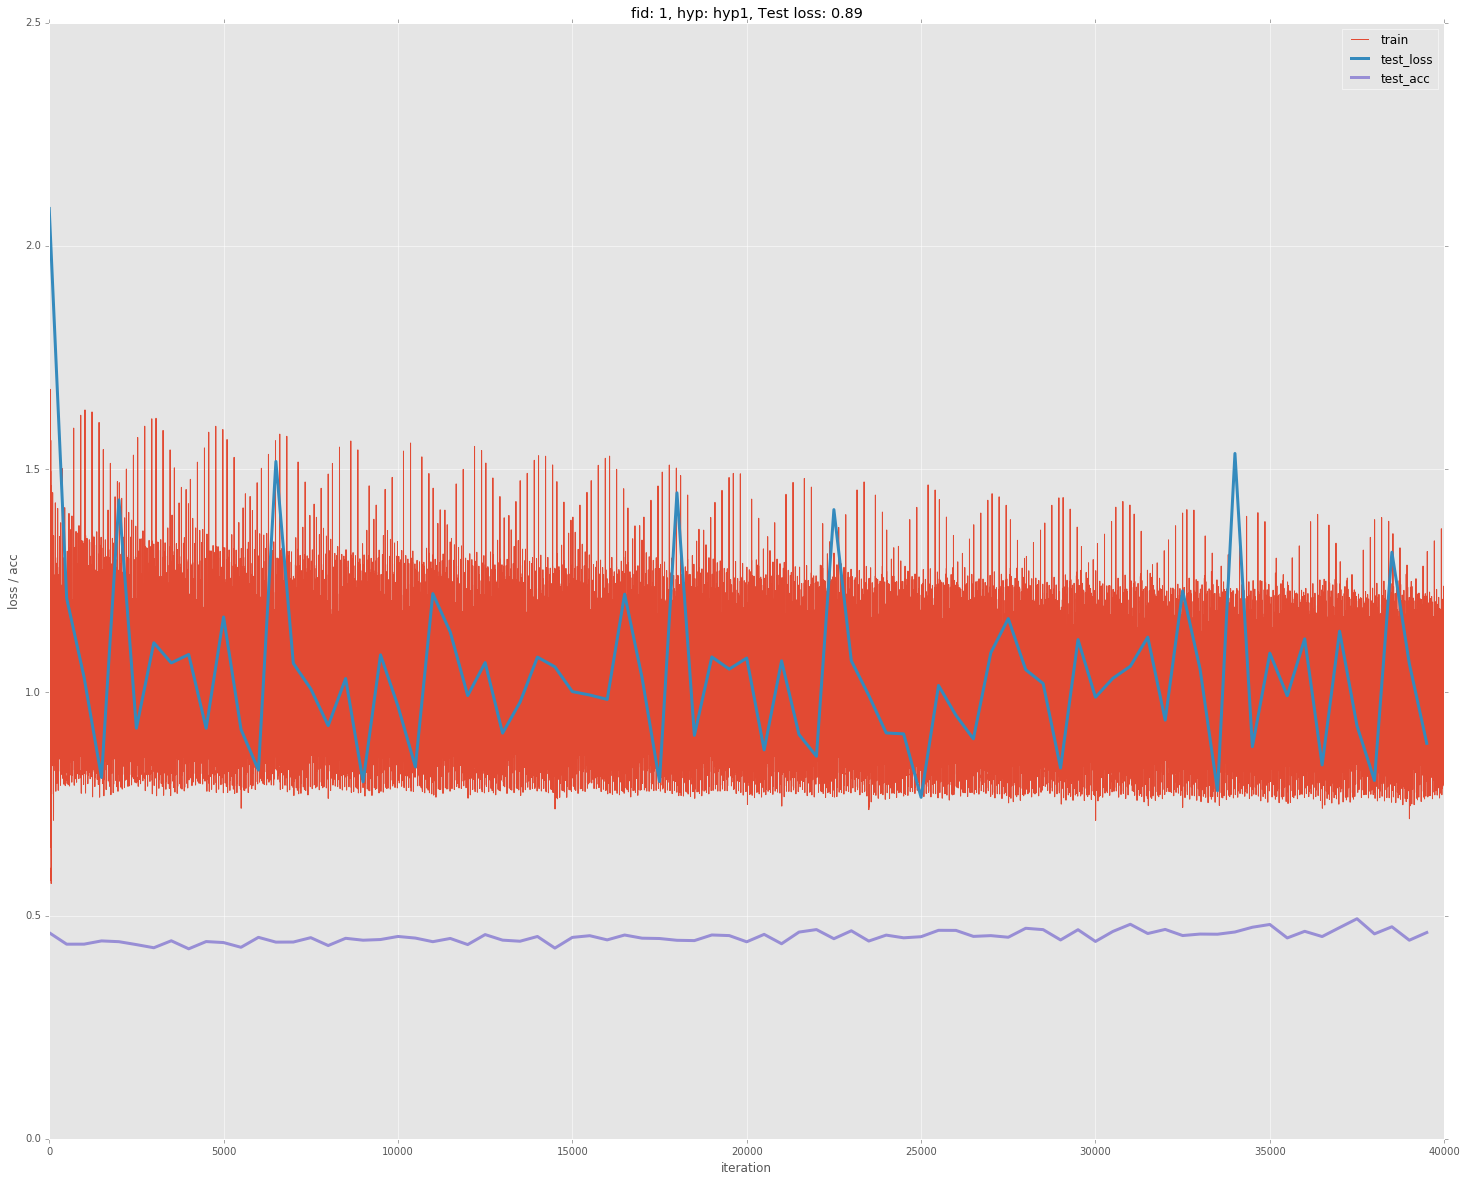

In [109]:
# plot train loss and acc
plt.rcParams['figure.figsize'] = (25, 20)
#niter = 30000
test_interval = 500
n_hype_configs = len(hype_configs.keys())
pid = 1
for hype in CV_perf_hype.keys(): 
    CV_perf = CV_perf_hype[hype]
    n_CV_configs = len(CV_perf)
    for fid in fid_list:        
        train_loss_list = CV_perf[fid]['train_loss']
        test_loss_list = CV_perf[fid]['test_loss']
        if multi_label:
            test_acc_list = CV_perf[fid]['test_acc']
        else: 
            test_acc_list = test_loss_list
        
        for train_loss, test_loss, test_acc in zip(train_loss_list,test_loss_list,test_acc_list):
            ax1 = plt.subplot(n_hype_configs,n_CV_configs,pid)            
            ax1.plot(arange(niter), train_loss, label='train')
            ax1.plot(test_interval * arange(len(test_loss)), test_loss, label='test_loss', linewidth='3')                            
            ax1.plot(test_interval * arange(len(test_acc)), test_acc, label='test_acc', linewidth='3')                            
            
            ax1.set_xlabel('iteration')
            ax1.set_ylabel('loss / acc')
            ax1.set_title('fid: {}, hyp: {}, Test loss: {:.2f}'.format(fid, hype, test_loss[-1]))
            ax1.legend(loc=1)
            #ax1.set_ylim(0,50)
        pid += 1

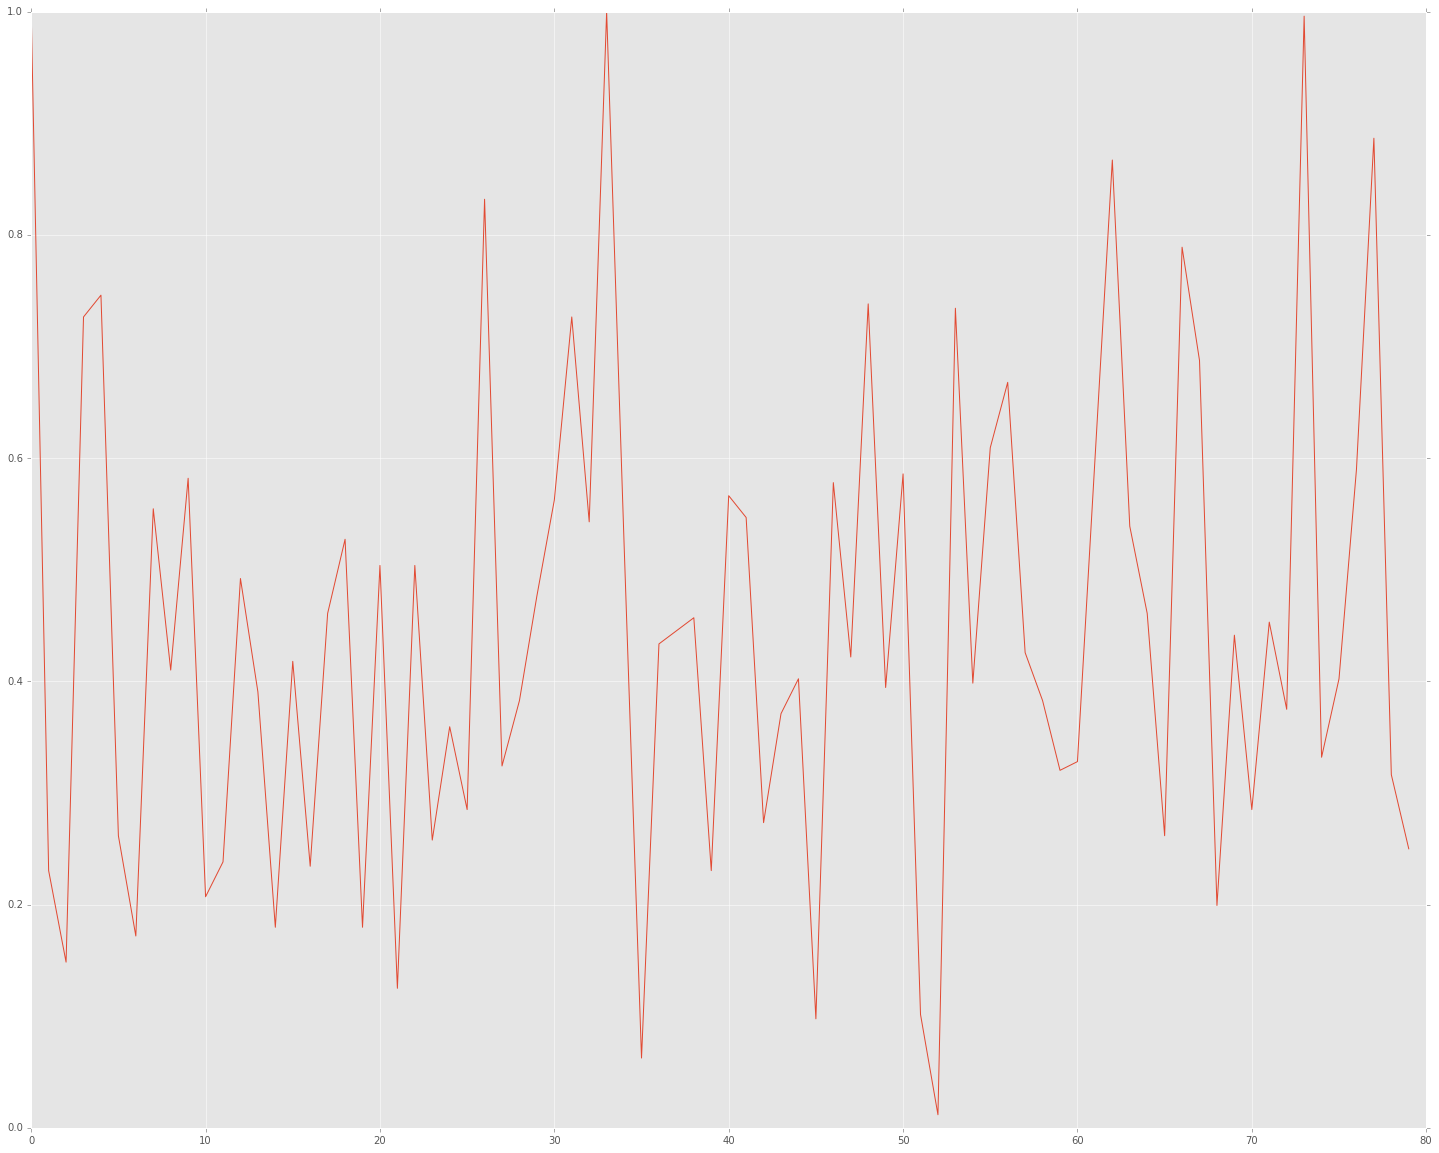

In [106]:
plt.plot(test_acc)

In [ ]:
#Get encodings after training
#train_filename_hdf = baseline_dir + 'data/train_CT_C688_normed.h5'
#test_filename_hdf = baseline_dir + 'data/test_CT_C688_normed.h5'
#fid=2
#exp_name = 'Exp11'
#niter = 20000
#modality = 'CT'
#start_fold = 1
#n_folds = 10
#fid_list = np.arange(start_fold,n_folds+1,1)
#preproc = 'no_preproc'
batch_size = 256
snap_interval = 2000
snap_start = 2000
encoding_layer = 'output'
#weight_layers = ['L_ff1','R_ff1','ff1','L_ff2','R_ff2','ff2','ff3']
weight_layers = ['ff3']
cohort = 'outer_test'
#Clinical_Scale = 'ADAS13'

if Clinical_Scale in ['ADAS13', 'MMSE']:
    fold_euLoss = {}
    fold_r = {}
    fold_act_scores = {}
    fold_pred_scores = {}
elif Clinical_Scale == 'BOTH':
    fold_euLoss_adas13 = {}
    fold_r_adas13 = {}
    fold_act_scores_adas13 = {}
    fold_pred_scores_adas13 = {}
    fold_euLoss_mmse = {}
    fold_r_mmse = {}
    fold_act_scores_mmse = {}
    fold_pred_scores_mmse = {}
    
print exp_name, modality

for hype in hype_configs.keys():      
    node_sizes = hype_configs[hype]['node_sizes']
    dr = hype_configs[hype]['dr']
    lr = hype_configs[hype]['lr']
    
    for fid in fid_list:
        if fid in [6,7,8]:
            preproc = 'ae_pretrain_HC60k_CT500k_hyp1' #fid=6,7,8
        elif fid in [9,10]:
            preproc = 'ae_pretrain_HC_CT_hyp1' #fid=9,10
        else:
            print 'wrong fid'
        test_filename_txt = baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)
        #test_filename_hdf = baseline_dir + 'API/data/fold{}/outer_test/{}_{}.h5'.format(fid,exp_name,preproc)
        #with open(test_filename_txt, 'w') as f:
        #        f.write(test_filename_hdf + '\n')  

        test_net_path = baseline_dir + 'API/data/fold{}/ADNI_FF_test.prototxt'.format(fid)
        with open(test_net_path, 'w') as f:
            if modality == 'HC':
                f.write(str(adninet_ff_HC(test_filename_txt, 256, node_sizes,dr,lr,tr,Clinical_Scale)))
                input_nodes = ['X_L_HC','X_R_HC']
            elif modality == 'CT':
                f.write(str(adninet_ff_CT(test_filename_txt, 256, node_sizes,dr,lr,tr,Clinical_Scale)))
                input_nodes = ['X_CT']
            elif modality == 'HC_CT':
                f.write(str(adninet_ff_HC_CT(test_filename_txt, 256, node_sizes,dr,lr,tr,Clinical_Scale)))
                input_nodes = ['X_L_HC','X_R_HC','X_CT']
            else:
                print 'Wrong modality'
    
        print 'Hype # {}, Fold # {}, Clinical_Scale {}'.format(hype, fid, Clinical_Scale)
        data_path = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name,preproc)
        if Clinical_Scale == 'ADAS13':
            act_scores = load_data(data_path, 'y','no_preproc')
        elif Clinical_Scale == 'MMSE': 
            act_scores = load_data(data_path, 'y3','no_preproc')
        elif Clinical_Scale == 'BOTH':
            act_scores_adas13 = load_data(data_path, 'y','no_preproc')
            act_scores_mmse = load_data(data_path, 'y3','no_preproc')
        else:
            print 'unknown clinical scale'
        
        net_file = baseline_dir + 'API/data/fold{}/ADNI_FF_test.prototxt'.format(fid)
        test_filename_hdf = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name,preproc)
        test_filename_txt = baseline_dir + 'API/data/fold{}/{}_C688.txt'.format(fid,cohort)
        with open(test_filename_txt, 'w') as f:
                f.write(test_filename_hdf + '\n')  
        
        sub.call(["cp", baseline_dir + 'API/data/fold{}/{}_C688.txt'.format(fid,cohort), baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)])
        #data_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp4_ADNI1_ADAS13_NN_valid.h5'
        #adas_scores = load_data(data_path, 'Fold_{}_y'.format(fid),'no_preproc')
        layer_weights = {}
        
        if Clinical_Scale in ['ADAS13', 'MMSE']:
            multi_task = False
            iter_euLoss = []
            iter_r = []        
            iter_pred_scores = []
            for snap_iter in np.arange(snap_start,niter+1,snap_interval):
                model_file = baseline_dir + 'API/data/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(fid,exp_name,hype,modality,snap_iter)        
                results = extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers,multi_task)
                encodings = np.squeeze(results['X_out'])            
                layer_weights[snap_iter] = results['wt_dict']  
                iter_pred_scores.append(np.squeeze(results['X_out']))            
                iter_euLoss.append(0.5*mse(encodings,act_scores))  #This is to be consistent with the caffe loss funtion
                iter_r.append(stats.pearsonr(encodings,act_scores)[0])

            config_idx = '{}_{}'.format(hype,fid)
            fold_euLoss[config_idx] = np.array(iter_euLoss)
            fold_r[config_idx] = np.array(iter_r)
            fold_act_scores[fid] = act_scores
            fold_pred_scores[config_idx] = np.array(iter_pred_scores)        
        
        elif Clinical_Scale == 'BOTH':
            multi_task = True
            iter_euLoss_adas13 = []
            iter_r_adas13 = []        
            iter_pred_scores_adas13 = []
            iter_euLoss_mmse = []
            iter_r_mmse = []        
            iter_pred_scores_mmse = []
                        
            for snap_iter in np.arange(snap_start,niter+1,snap_interval):
                model_file = baseline_dir + 'API/data/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(fid,exp_name,hype,modality,snap_iter)        
                results = extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers,multi_task)
                encodings = results['X_out']  
                layer_weights[snap_iter] = results['wt_dict']  
                encodings_adas13 = np.squeeze(encodings['adas13'])
                encodings_mmse = np.squeeze(encodings['mmse'])
                iter_pred_scores_adas13.append(encodings_adas13)            
                iter_pred_scores_mmse.append(encodings_mmse)                 
                iter_euLoss_adas13.append(0.5*mse(encodings_adas13,act_scores_adas13))  #This is to be consistent with the caffe loss funtion
                iter_euLoss_mmse.append(0.5*mse(encodings_mmse,act_scores_mmse))  #This is to be consistent with the caffe loss funtion
                iter_r_adas13.append(stats.pearsonr(encodings_adas13,act_scores_adas13)[0])                                
                iter_r_mmse.append(stats.pearsonr(encodings_mmse,act_scores_mmse)[0])

            config_idx = '{}_{}'.format(hype,fid)
            fold_euLoss_adas13[config_idx] = np.array(iter_euLoss_adas13)
            fold_r_adas13[config_idx] = np.array(iter_r_adas13)
            fold_act_scores_adas13[fid] = act_scores_adas13
            fold_pred_scores_adas13[config_idx] = np.array(iter_pred_scores_adas13)        
            fold_euLoss_mmse[config_idx] = np.array(iter_euLoss_mmse)
            fold_r_mmse[config_idx] = np.array(iter_r_mmse)
            fold_act_scores_mmse[fid] = act_scores_mmse
            fold_pred_scores_mmse[config_idx] = np.array(iter_pred_scores_mmse)        
        
        

In [ ]:
plt.rcParams['figure.figsize'] = (20,40)
layer = 'ff3' 

for sn, snap_iter in enumerate(np.arange(snap_start,niter+1,snap_interval)):
    wt_map = layer_weights[snap_iter][layer]    
    plt.subplot(ceil(len(np.arange(snap_start,niter+1,snap_interval))/2),2,sn+1)    
    imshow(layer_weights[snap_iter][layer])
    plt.title(snap_iter)
    plt.colorbar()    

In [ ]:
multi_task

In [ ]:
plt.rcParams['figure.figsize'] = (20, 5)
n_rows = 1
n_cols = 2
pid = 1
if multi_task:
    euLosses = [fold_euLoss_adas13,fold_euLoss_mmse]
    corrs = [fold_r_adas13,fold_r_mmse]
else:
    euLosses = [fold_euLoss]
    corrs = [fold_r]
    
for fold_euLoss, fold_r in zip(euLosses, corrs):
    for hype_fid in fold_euLoss.keys():
        hype = int(hype_fid.split('_')[0][3])
        fid = int(hype_fid.split('_')[1])    
        plt.figure(fid)
        plt.subplot(n_rows,n_cols,1)
        plt.plot(np.arange(snap_start,niter+1,snap_interval),fold_euLoss[hype_fid],label=hype_fid)
        plt.title('Euclidean loss , fid: {}'.format(fid))
        plt.legend()
        plt.subplot(n_rows,n_cols,2)
        plt.plot(np.arange(snap_start,niter+1,snap_interval),fold_r[hype_fid],label=hype_fid)
        plt.title('correlation, fid: {}'.format(fid))
        plt.legend(loc=2)


In [ ]:
fold_r_dict = {}
fold_euLoss_dict = {}
fold_act_scores_dict = {}
fold_pred_scores_dict = {}

if multi_task:
    fold_r_dict['ADAS'] = fold_r_adas13
    fold_r_dict['MMSE'] = fold_r_mmse
    fold_euLoss_dict['ADAS'] = fold_euLoss_adas13
    fold_euLoss_dict['MMSE'] = fold_euLoss_mmse
    fold_act_scores_dict['ADAS'] = fold_act_scores_adas13
    fold_act_scores_dict['MMSE'] = fold_act_scores_mmse
    fold_pred_scores_dict['ADAS'] = fold_pred_scores_adas13
    fold_pred_scores_dict['MMSE'] = fold_pred_scores_mmse
    
else:    
    fold_r_dict = fold_r
    fold_euLoss_dict = fold_euLoss
    fold_act_scores_dict = fold_act_scores
    fold_pred_scores_dict = fold_pred_scores
    
opt_metric = 'corr'

Clinical_Scale = 'BOTH'
task_weights = {'ADAS':1,'MMSE':1}
NN_results = computePerfMetrics(fold_r_dict, fold_euLoss_dict, fold_act_scores_dict, fold_pred_scores_dict, opt_metric, hype_configs, Clinical_Scale,task_weights)

adas_r = NN_results['opt_ADAS']['CV_r'].values()
mmse_r = NN_results['opt_MMSE']['CV_r'].values()
adas_mse = NN_results['opt_ADAS']['CV_MSE'].values()
mmse_mse = NN_results['opt_MMSE']['CV_MSE'].values()


print 'ADAS corr: {}'.format(NN_results['opt_ADAS']['CV_r'])
print 'ADAS mse: {}'.format(NN_results['opt_ADAS']['CV_MSE'])
print 'ADAS means: {}, {}'.format(np.mean(adas_r),np.mean(adas_mse))
print ''
print 'MMSE corr: {}'.format(NN_results['opt_MMSE']['CV_r'])
print 'MMSE mse: {}'.format(NN_results['opt_MMSE']['CV_MSE'])
print 'MMSE means: {}, {}'.format(np.mean(mmse_r),np.mean(mmse_mse))
print ''
#print opt_configs['opt_hype']

save_multitask_results = False
if save_multitask_results:
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    montage_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'  
    save_name = '{}Exp11_ADNI2_ADAS13_MMSE_NN_{}_{}.pkl'.format(montage_dir,modality,st)
    print 'saving results at: {}'.format(save_name)
    output = open(save_name, 'wb')
    pickle.dump(NN_results, output)
    output.close()

In [ ]:
# Compute ptimal hyp_config for each fold(based on inner_test)
# if multi_task is set then compute hyp_config based on ADAS+MMSE perf (mse, r values)
# if multi_task is set then ADAS and MMSE act_scores and pred_scores are wrapped in dictionaries 
# task_weights: dict of weights for each task --> only used in Clinical_Scale = BOTH
# opt_metric = mse or corr
def computePerfMetrics(fold_r, fold_euLoss, fold_act_scores, fold_pred_scores, opt_metric, hype_configs, Clinical_Scale,task_weights):
    # First generate lists per fold with all hyp results
    fid_hype_map = defaultdict(list)
    fid_euLoss_perf= defaultdict(list)
    fid_r_perf= defaultdict(list)
    
     # find optimal hyp_snp combination for each fold based on corr and euLoss
    opt_hype = {}

    opt_r_adas = {}
    opt_mse_adas = {}
    actual_scores_adas = defaultdict(list)
    opt_pred_scores_adas = defaultdict(list)

    opt_r_mmse = {}
    opt_mse_mmse = {}
    actual_scores_mmse = defaultdict(list)
    opt_pred_scores_mmse = defaultdict(list)

    print 'Clinical_Scale: {}'.format(Clinical_Scale)
    if not Clinical_Scale == 'BOTH':  #Does not produce all the metrics yet..
        print 'This function does not work for single clinical scale models. Use the code from the next cell'
    
    else:
        fold_r_ADAS = fold_r['ADAS']
        fold_r_MMSE = fold_r['MMSE']
        fold_euLoss_ADAS = fold_euLoss['ADAS']
        fold_euLoss_MMSE = fold_euLoss['MMSE']
        fid_r_perf_ADAS = defaultdict(list)
        fid_r_perf_MMSE = defaultdict(list)
        fid_euLoss_perf_ADAS = defaultdict(list)
        fid_euLoss_perf_MMSE = defaultdict(list)
        for hype_fid in fold_euLoss_ADAS.keys():
            hype = int(hype_fid.split('_')[0][3])
            fid = int(hype_fid.split('_')[1]) 
            
            fid_r_perf_ADAS[fid].append(fold_r_ADAS[hype_fid])
            fid_r_perf_MMSE[fid].append(fold_r_MMSE[hype_fid])
            fid_euLoss_perf_ADAS[fid].append(fold_euLoss_ADAS[hype_fid])
            fid_euLoss_perf_MMSE[fid].append(fold_euLoss_MMSE[hype_fid])
            fid_hype_map[fid].append(hype)
            
            #Joint scores (weighted addition)
            fid_r_perf[fid].append(task_weights['ADAS']*fold_r_ADAS[hype_fid] + task_weights['MMSE']*fold_r_MMSE[hype_fid])
            fid_euLoss_perf[fid].append(task_weights['ADAS']*fold_euLoss_ADAS[hype_fid] + task_weights['MMSE']*fold_euLoss_MMSE[hype_fid])

        fold_act_scores_adas = fold_act_scores['ADAS']
        fold_act_scores_mmse = fold_act_scores['MMSE']
        fold_pred_scores_adas = fold_pred_scores['ADAS']
        fold_pred_scores_mmse = fold_pred_scores['MMSE']

        for fid in fid_hype_map.keys():
            r_perf_array_adas = np.array(fid_r_perf_ADAS[fid])
            r_perf_array_mmse = np.array(fid_r_perf_MMSE[fid])
            r_perf_array = np.array(fid_r_perf[fid])
            euLoss_perf_array_adas = np.array(fid_euLoss_perf_ADAS[fid])
            euLoss_perf_array_mmse = np.array(fid_euLoss_perf_MMSE[fid])
            euLoss_perf_array = np.array(fid_euLoss_perf[fid])

            if opt_metric == 'euLoss':
                h,snp = np.unravel_index(euLoss_perf_array.argmin(), euLoss_perf_array.shape)
            else:
                h,snp = np.unravel_index(r_perf_array.argmax(), r_perf_array.shape)

            opt_hype[fid] = hype_configs['hyp{}'.format(fid_hype_map[fid][h])]

            opt_r_adas[fid] = r_perf_array_adas[h,snp]
            opt_mse_adas[fid] = 2*euLoss_perf_array_adas[h,snp] #Convert back to MSE
            opt_r_mmse[fid] = r_perf_array_mmse[h,snp] 
            opt_mse_mmse[fid] = 2*euLoss_perf_array_mmse[h,snp] #Convert back to MSE

            actual_scores_adas[fid].append(fold_act_scores_adas[fid])
            opt_pred_scores_adas[fid].append(fold_pred_scores_adas['hyp{}_{}'.format(fid_hype_map[fid][h],fid)][snp])
            actual_scores_mmse[fid].append(fold_act_scores_mmse[fid])
            opt_pred_scores_mmse[fid].append(fold_pred_scores_mmse['hyp{}_{}'.format(fid_hype_map[fid][h],fid)][snp])

        opt_ADAS = {'CV_r':opt_r_adas,'CV_MSE':opt_mse_adas,'actual_CV_scores':actual_scores_adas,'predicted_CV_scores':opt_pred_scores_adas}
        opt_MMSE = {'CV_r':opt_r_mmse,'CV_MSE':opt_mse_mmse,'actual_CV_scores':actual_scores_mmse,'predicted_CV_scores':opt_pred_scores_mmse}
    
    return {'opt_hype':opt_hype, 'opt_ADAS':opt_ADAS, 'opt_MMSE':opt_MMSE}


In [ ]:
# Find optimal config based on inner_test
euLosses = [fold_euLoss]
corrs = [fold_r]
act_scores = [fold_act_scores]
pred_scores = [fold_pred_scores]
Clinical_Scales = ['ADAS13']
NN_multitask_results = {}
for Clinical_Scale, fold_euLoss, fold_r, fold_act_scores, fold_pred_scores in zip(Clinical_Scales, euLosses, corrs, act_scores, pred_scores):
    snap_array = np.arange(snap_start,niter+1,snap_interval)

    fid_hype_map = defaultdict(list)
    fid_euLoss_perf= defaultdict(list)
    fid_r_perf= defaultdict(list)
    for hype_fid in fold_euLoss.keys():
        hype = int(hype_fid.split('_')[0][3])
        fid = int(hype_fid.split('_')[1])
        fid_euLoss_perf[fid].append(fold_euLoss[hype_fid])
        fid_r_perf[fid].append(fold_r[hype_fid])
        fid_hype_map[fid].append(hype)

    opt_r = []
    opt_mse = []
    opt_hype = []
    actual_scores = []
    opt_pred_scores = []

    for fid in fid_hype_map.keys():
        r_perf_array = np.array(fid_r_perf[fid])
        euLoss_perf_array = np.array(fid_euLoss_perf[fid])
        
        # if want to find best hyp from mse values
        h,snp = np.unravel_index(euLoss_perf_array.argmin(), euLoss_perf_array.shape)
        eu_loss = euLoss_perf_array[h,snp]
        opt_mse.append(2*eu_loss)        
        r = r_perf_array[h,snp]        
        opt_r.append(r)
        print 'fid:{}, best hype:{}, snap: {}, euLoss:{}'.format(fid, fid_hype_map[fid][h],snap_array[snp],eu_loss)
        
#         h,snp = np.unravel_index(r_perf_array.argmax(), r_perf_array.shape)
#         r = r_perf_array[h,snp]        
#         opt_r.append(r)
#         eu_loss = euLoss_perf_array[h,snp]
#         opt_mse.append(2*eu_loss)
        
        opt_hype.append(hype_configs['hyp{}'.format(fid_hype_map[fid][h])])
        
        print 'fid:{}, best hype:{}, snap: {}, r:{}, euLoss:{}'.format(fid, fid_hype_map[fid][h],snap_array[snp],r,eu_loss)        
        actual_scores.append(fold_act_scores[fid])  
        opt_pred_scores.append(fold_pred_scores['hyp{}_{}'.format(fid_hype_map[fid][h],fid)][snp])
        
    print 'CV Perf: r:{}, mse:{}'.format(np.mean(opt_r), np.mean(opt_mse))
    print opt_r
    print opt_mse
    NN_multitask_results[Clinical_Scale] = {'opt_r':opt_r,'opt_mse':opt_mse,'opt_hype':opt_hype,
                                            'actual_scores':actual_scores,'opt_pred_scores':opt_pred_scores}
    

In [ ]:

# Exp11_ADNI2_ADAS13_NN_HC_CT_2016-05-06-10-27-02.pkl
# old CV_r: [0.58713291550558833, 0.74574527911517141, 0.71271529005993939, 0.71772651594819259, 0.68488215732574409, 
#            0.64485628063795464, 0.59854968077229798, 0.6848414923548054, 0.60031497549309831, 0.57364714888913393]
# old CV_mse:[59.060642573000067, 49.994822378856952, 42.505167081404124, 41.230911409916544, 62.596431523635779, 
#  45.418731041811768, 75.699131356850913, 45.237745781162964, 64.553970362370492, 70.207087566978927]

# Exp11_ADNI2_MMSE_NN_HC_CT_2016-05-15-19-59-42.pkl
# old CV_r: [0.48038349554607179, 0.60131716074726682, 0.53198020733649787, 0.64770981175015141, 0.56547528703482142,
#            0.52085739989088009, 0.65811053610310188, 0.57630405337929402, 0.51059593904907996, 0.48178577037836778]

boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'
# model_files = ['Exp7_ADNI2_ADAS13_NN_HC_CT_2016-05-01-13-46-16.pkl',
#                'Exp7_ADNI2_ADAS13_NN_HC_CT_2016-05-02-10-29-55.pkl', 'Exp7_ADNI2_ADAS13_NN_HC_CT_2016-05-03-19-02-13.pkl']

model_file = 'Exp11_ADNI2_ADAS13_NN_HC_CT_2016-08-03-20-27-06.pkl'
print model_file
CV_data = pickle.load(open(boxplots_dir + model_file,'rb'))

print 'old CV_r: {}'.format(CV_data['CV_r'])
print ''
print 'old mean(CV_r): {}, mean(MSE): {}'.format(np.mean(CV_data['CV_r']),np.mean(CV_data['CV_MSE']))
print ''
print 'old CV_mse: {}'.format(CV_data['CV_MSE'])
#print CV_data['tid_snap_config_dict']

NN_results = {}
NN_results['CV_MSE'] = opt_mse
NN_results['CV_r'] = opt_r
NN_results['predicted_CV_scores'] = opt_pred_scores
NN_results['actual_CV_scores'] = actual_scores
NN_results['tid_snap_config_dict'] = opt_hype

# #Combine second saved perf file with the previous one
# model_file_2 = 'Exp11_ADNI2_ADAS13_NN_HC_CT_2016-05-06-00-03-01.pkl'
# print model_file
# NN_results = pickle.load(open(boxplots_dir + model_file_2,'rb'))

idx_pairs = {9:0}
updated_CV_data = update_fold_perf(boxplots_dir + model_file, NN_results, idx_pairs)
print ''
print 'new CV_r: {}'.format(updated_CV_data['CV_r'])
print ''
print 'new mean(CV_r): {}, mean(MSE): {}'.format(np.mean(updated_CV_data['CV_r']),np.mean(updated_CV_data['CV_MSE']))
print ''
print 'new CV_mse: {}'.format(updated_CV_data['CV_MSE'])

save_updated_perf = False
if save_updated_perf:
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    montage_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'  
    save_name = '{}Exp11_ADNI2_ADAS13_NN_{}_{}.pkl'.format(montage_dir,modality,st)
    print 'saving results at: {}'.format(save_name)
    output = open(save_name, 'wb')
    pickle.dump(updated_CV_data, output)
    output.close()
    

In [ ]:
[0.57729130647024818]
[68.824274706765621]

In [ ]:
#Update fold performance for multitask
print NN_results['opt_ADAS'].keys()

boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'
#model_file = 'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-06-04-13-15-43.pkl'
model_file_soa = 'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-07-14-17-13-19.pkl'
print 'current state of art: ' + model_file_soa
CV_data = pickle.load(open(boxplots_dir + model_file_soa,'rb'))

print 'ADAS'
print CV_data['opt_ADAS']['CV_r']
print CV_data['opt_ADAS']['CV_MSE']
print np.mean(CV_data['opt_ADAS']['CV_r'].values())
print np.mean(CV_data['opt_ADAS']['CV_MSE'].values())
print 'MMSE'
print CV_data['opt_MMSE']['CV_r']
print CV_data['opt_MMSE']['CV_MSE']
print np.mean(CV_data['opt_MMSE']['CV_r'].values())
print np.mean(CV_data['opt_MMSE']['CV_MSE'].values())

#load old file
model_file = 'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-06-03-19-29-16_Fold9_10.pkl'
print 'updated fold result file: ' + model_file
NN_results = pickle.load(open(boxplots_dir + model_file,'rb'))

idx_pairs = {6:0}
CV_data = update_multifold_perf(boxplots_dir + model_file_soa, NN_results, idx_pairs)

print ""
print 'updated CV_data'
print 'ADAS'
print CV_data['opt_ADAS']['CV_r']
print CV_data['opt_ADAS']['CV_MSE']
print np.mean(CV_data['opt_ADAS']['CV_r'].values())
print np.mean(CV_data['opt_ADAS']['CV_MSE'].values())
print 'MMSE'
print CV_data['opt_MMSE']['CV_r']
print CV_data['opt_MMSE']['CV_MSE']
print np.mean(CV_data['opt_MMSE']['CV_r'].values())
print np.mean(CV_data['opt_MMSE']['CV_MSE'].values())

save_name = '{}Exp11_ADNI2_ADAS13_MMSE_NN_{}_{}.pkl'.format(montage_dir,modality,st)
#print 'saving results at: {}'.format(save_name)

save_updated_perf = False
if save_updated_perf:
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    montage_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'  
    save_name = '{}Exp11_ADNI2_ADAS13_MMSE_NN_{}_{}.pkl'.format(montage_dir,modality,st)
    print 'saving results at: {}'.format(save_name)
    output = open(save_name, 'wb')
    pickle.dump(CV_data, output)
    output.close()


In [ ]:

Clinical_Scale: BOTH
ADAS corr: [0.60970935188889275]
ADAS mse: [77.502303043121842]
ADAS means: 0.609709351889, 77.5023030431

MMSE corr: [0.62435863520144907]
MMSE mse: [4.4640331257620778]
MMSE means: 0.624358635201, 4.46403312576

In [ ]:
import pickle
import time
import datetime

def update_fold_perf(saved_perf_file, new_perf_dict,idx_pairs): #idx_pairs={'old_idx':new_idx}
    CV_data = pickle.load(open(saved_perf_file,'rb'))    
    for key in CV_data.keys():
        for idx in idx_pairs.keys():
            CV_data[key][idx] = new_perf_dict[key][idx_pairs[idx]]
        
    return CV_data

def update_multifold_perf(saved_perf_file, new_perf_dict, idx_pairs):    
    perf_metrics = ['CV_r', 'actual_CV_scores', 'CV_MSE', 'predicted_CV_scores']    
    CV_data = pickle.load(open(saved_perf_file,'rb'))    
    for key in CV_data.keys():
        if key == 'opt_hype':
            for idx_key,idx_val in idx_pairs.iteritems():
                CV_data[key][idx_key] = new_perf_dict[key][idx_val]
                
        else:
            for pm in perf_metrics:
                for idx_key,idx_val in idx_pairs.iteritems():
                    CV_data[key][pm][idx_key] = new_perf_dict[key][pm][idx_val]
    
    return CV_data
    

In [ ]:
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'
model_files = ['Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-06-04-13-15-43.pkl',             
             'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-05-23-07-31-29.pkl']

#'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-06-03-19-29-16_Fold9_10.pkl'

Clinical_Scale = 'ADAS'
perf_array = []
for mf in model_files:
    CV_data = pickle.load(open(boxplots_dir + mf,'rb'))['opt_{}'.format(Clinical_Scale)]        
    perf_array.append(CV_data['CV_r'].values())

print (np.max(np.array(perf_array),axis=0))
print np.mean(np.max(np.array(perf_array),axis=0))

In [ ]:
import time
import datetime

#print 'modality: {} mse: {}, r: {}'.format(modality, np.mean(2*np.array(fold_euLoss)[:,-1]),np.mean(np.array(fold_r)[:,-1]))
#CV_perf ={'fid_list': fid_hype_map.keys(), 'hype_configs':opt_hype,'fold_mse':opt_mse,'fold_r':opt_r}
#pickleIt(CV_perf, baseline_dir + 'API/CV_perf/outer_test_{}.pkl'.format(modality))
#print "Saving opt perf for fids: {} with modality: {}".format(fid_hype_map.keys(),modality)


save_detailed_results = True
multi_task = True

if save_detailed_results:
    # dictionaries for summarized results    
    if not multi_task:
        NN_results = {}
        NN_results['CV_MSE'] = opt_mse
        NN_results['CV_r'] = opt_r
        NN_results['predicted_CV_scores'] = opt_pred_scores
        NN_results['actual_CV_scores'] = actual_scores
        NN_results['tid_snap_config_dict'] = opt_hype
        print opt_r
        print opt_mse
        
    else:
        NN_results = NN_multitask_results
        print 'ADAS13, opt_r: {}'.format(NN_multitask_results['ADAS13']['opt_r'])
        print 'ADAS13, opt_mse {}: '.format(NN_multitask_results['ADAS13']['opt_mse'])
        print 'MMSE, opt_r: {}'.format(NN_multitask_results['MMSE']['opt_r'])
        print 'MMSE, opt_mse: {}'.format(NN_multitask_results['MMSE']['opt_mse'])
        
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    montage_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'  
    save_name = '{}Exp6_ADNI1_BOTH_NN_{}_{}.pkl'.format(montage_dir,modality,st)
    print 'saving results at: {}'.format(save_name)
    output = open(save_name, 'wb')
    pickle.dump(NN_results, output)
    output.close()

In [ ]:
def generate_APIdata(in_data_path,out_data_path,fid,modality,preproc, CS_only):
    print in_data_path
    #Input config file generation
    in_data = load_data(in_data_path, 'Fold_{}_X_{}'.format(fid,modality), preproc)
    # get labels (no_preproc)        

    # HDF5 is pretty efficient, but can be further compressed.
    comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
    with h5py.File(out_data_path, 'a') as f:
        if not CS_only:
            if modality == 'R_CT': #Fix the typo
                #Because we have separate ADNI1+2 cohort for ADAS13 no need to create 'y'
                in_label = load_data(in_data_path, 'Fold_{}_y'.format(fid), 'no_preproc') 
                modality = 'CT'
                f.create_dataset('y', data=in_label, **comp_kwargs)

            f.create_dataset('X_{}'.format(modality), data=in_data, **comp_kwargs)
        else:
            if modality == 'R_CT': #Fix the typo
                in_label = load_data(in_data_path, 'Fold_{}_y3'.format(fid), 'no_preproc')
                f.create_dataset('y3', data=in_label, **comp_kwargs)
        

In [ ]:
#Generate API style data (options: scale / normalize)
exp_name = 'Exp11'
exp_name_out = 'Exp11_norm'
cohorts = ['inner_train','inner_test','outer_test']
modalities = ['L_HC','R_HC','R_CT']
dataset = 'ADNI2'
Clinical_Scale = 'ADAS13'
CS_only = False

for fid in np.arange(9,11,1):
    for modality in modalities:
        if modality == 'R_CT':
            preproc = 'scale' 
        else:
            preproc = 'no_preproc' #binary labels
            
        for cohort in cohorts:            
            if cohort == 'inner_train':
                in_data_path = baseline_dir + 'caffe_input/CV_{}_{}_{}_NN_OuterFold_{}_train_InnerFold_1.h5'.format(exp_name,dataset,Clinical_Scale,fid)
            elif cohort == 'inner_test':
                in_data_path = baseline_dir + 'caffe_input/CV_{}_{}_{}_NN_OuterFold_{}_valid_InnerFold_1.h5'.format(exp_name,dataset,Clinical_Scale,fid)
            else:                
                in_data_path = baseline_dir + 'CV_{}_{}_{}_NN_valid.h5'.format(exp_name,dataset,Clinical_Scale)

            out_data_path = baseline_dir + 'API/data/fold{}/{}/{}.h5'.format(fid,cohort,exp_name_out)

            generate_APIdata(in_data_path,out_data_path,fid,modality,preproc, CS_only)

In [ ]:
HC: fid[1:4] 8000; fid[5,6] 6000, fid[7,8,9]: 8000 fid 10: 6000
CT: fid[1:5] 12000 fid[6:10] 6000

#spawn net
ADNI_FF_train_hyp1_CT.prototxt

In [ ]:
# Net surgery AE --> FF pretrained weights
#Review new FF net params
modality = 'HC_CT'
pretrain_snap_HC = 4000
pretrain_snap_CT = 6000
n_folds = 10

#Custom snaps per fold
#HC_iter = [8000,8000,8000,8000,6000,6000,8000,8000,8000,6000]
#CT_iter = [12000,12000,12000,12000,12000,6000,6000,6000,6000,6000]

hyp = 'hyp2'
for fid in np.arange(1,n_folds+1,1):
    print 'fid: {}'.format(fid)
    #for AE_branch in ['CT','R_HC','L_HC']:
    for AE_branch in ['CT','HC']:
        print 'AE_branch: {}'.format(AE_branch)

        if AE_branch == 'L_HC':
            params_FF = ['L_ff1', 'L_ff2']            
            AE_iter = 12000
        elif AE_branch == 'R_HC':
            params_FF = ['R_ff1', 'R_ff2']            
            AE_iter = 12000
        elif AE_branch == 'HC':
            params_FF = ['L_ff1','R_ff1']
            AE_iter = pretrain_snap_HC
        elif AE_branch == 'CT':
            #params_FF = ['ff1', 'ff2']
            params_FF = ['ff1']
            AE_iter = pretrain_snap_HC
            #fid for pretain is 1 because it's same definition for all the folds.
            #Only use this during 1 of the modalities to avoid overwritting
            print 'Spawning new net'
            pretrain_net = caffe.Net(baseline_dir + 'API/data/fold{}/ADNI_FF_train_{}_{}.prototxt'.format(1,hyp,modality), caffe.TRAIN)
        else:
            print 'Wrong AE branch'

        # conv_params = {name: (weights, biases)}
        conv_params = {pr: (pretrain_net.params[pr][0].data, pretrain_net.params[pr][1].data) for pr in params_FF}

        for conv in params_FF:
            print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

        # Review AE net params 
        #fid for pretain is 1 because it's same definition for all the folds.
        net_file = baseline_dir + 'API/data/fold{}/ADNI_FF_train_{}_{}.prototxt'.format(1,hyp,AE_branch)
        #model_file = baseline_dir + 'API/data/fold{}/train_snaps/AE_snaps/AE_{}_iter_{}.caffemodel'.format(fid,AE_branch,AE_iter) 
        model_file = baseline_dir + 'API/data/fold{}/train_snaps/Exp11_{}_{}_iter_{}.caffemodel'.format(fid,hyp,AE_branch,AE_iter) 

        AE_net = caffe.Net(net_file, model_file, caffe.TEST)
        #params_AE = ['encoder1', 'code']
        params_AE = params_FF #if you are using pretrained NN
        
        # fc_params = {name: (weights, biases)}
        fc_params = {pr: (AE_net.params[pr][0].data, AE_net.params[pr][1].data) for pr in params_AE}

        for fc in params_AE:
            print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

        #transplant net parameters
        for pr, pr_conv in zip(params_AE, params_FF):
            conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
            conv_params[pr_conv][1][...] = fc_params[pr][1]

        save_net = True
        if save_net:
            save_path = baseline_dir + 'API/data/fold{}/pretrained_models/adni_ff_{}_{}_HC_snap_{}_CT_snap_{}_Sup_Concat.caffemodel'.format(fid,hyp,modality,pretrain_snap_HC,pretrain_snap_CT)
            print "Saving net to " + save_path
            pretrain_net.save(save_path)

In [ ]:
import pickle
CT_data = pickle.load(open('/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/Exp4_ADNI1_ADAS13_NN_CT_2016-03-01-11-18-48.pkl','rb'))
CT_data.keys()

In [ ]:
pred = fold_pred_scores['hyp1_1'][5] #CT_data['predicted_CV_scores'][1]
act = fold_act_scores[1] #CT_data['actual_CV_scores'][1]
print act
#print CT_data['tid_snap_config_dict']
print 'Euclidean loss: {}'.format(0.5*mse(pred,act))
print stats.pearsonr(pred,act)
plt.scatter(pred,act)

In [ ]:
fold_pred_scores['hyp1_1'][5]

In [ ]:
fid = 1
exp_name = 'Exp6'
preproc = 'no_preproc'
train_filename_hdf = baseline_dir + 'API/data/fold{}/inner_train/{}_{}.h5'.format(fid,exp_name,preproc)
inner_test_filename_hdf = baseline_dir + 'API/data/fold{}/inner_test/{}_{}.h5'.format(fid,exp_name,preproc)
outer_test_filename_hdf = baseline_dir + 'API/data/fold{}/outer_test/{}_{}.h5'.format(fid,exp_name,preproc)
train_data = load_data(train_filename_hdf, 'X_R_HC', preproc)
inner_test_data = load_data(inner_test_filename_hdf, 'X_R_HC', preproc)
outer_test_data = load_data(outer_test_filename_hdf, 'X_R_HC', preproc)
train_y = load_data(train_filename_hdf, 'y', preproc)
inner_test_y = load_data(inner_test_filename_hdf, 'y', preproc)
outer_test_y = load_data(outer_test_filename_hdf, 'y', preproc)


In [ ]:
print train_data.shape, inner_test_data.shape, outer_test_data.shape
print np.mean(np.sum(train_data,axis=1)), np.mean(np.sum(inner_test_data,axis=1)), np.mean(np.sum(outer_test_data,axis=1))
print np.mean(train_y), np.mean(inner_test_y), np.mean(outer_test_y)

In [ ]:
(17358, 16086) (4340, 16086) (71, 16086)
3377.85793294 3403.70506912 3427.98591549
15.4938933057 15.7380184332 15.7605633803

In [ ]:
CV_data['opt_ADAS']['CV_r']

In [14]:
1e4

10000.0